In [13]:
# Final preprocessing solution - aspect-ratio preserving padding
print("\n" + "="*60)
print("FINAL SOLUTION: 320x320 GRAYSCALE WITH ASPECT-RATIO PADDING")
print("="*60)

def preprocess_image_for_model(image, target_size=320):
    """Preprocess image to 320x320 grayscale with aspect-ratio preserving padding."""
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    height, width = gray.shape
    
    # Calculate scale to fit within target_size while preserving aspect ratio
    scale = min(target_size / width, target_size / height)
    
    # Calculate new dimensions
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    # Resize image
    resized = cv2.resize(gray, (new_width, new_height))
    
    # Create padded image with white background
    padded = np.full((target_size, target_size), 255, dtype=np.uint8)
    
    # Calculate padding offsets (center the image)
    y_offset = (target_size - new_height) // 2
    x_offset = (target_size - new_width) // 2
    
    # Place resized image in center
    padded[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized
    
    # Convert back to 3-channel for YOLO
    preprocessed = cv2.cvtColor(padded, cv2.COLOR_GRAY2BGR)
    
    return preprocessed, scale, x_offset, y_offset

def convert_coordinates_to_original(bbox_320, scale, x_offset, y_offset, orig_width, orig_height):
    """Convert bounding box coordinates from 320x320 back to original image."""
    x1_320, y1_320, x2_320, y2_320 = bbox_320
    
    # Convert back to original coordinates
    x1_orig = int((x1_320 - x_offset) / scale)
    y1_orig = int((y1_320 - y_offset) / scale)
    x2_orig = int((x2_320 - x_offset) / scale)
    y2_orig = int((y2_320 - y_offset) / scale)
    
    # Clamp to image bounds
    x1_orig = max(0, min(orig_width, x1_orig))
    y1_orig = max(0, min(orig_height, y1_orig))
    x2_orig = max(0, min(orig_width, x2_orig))
    y2_orig = max(0, min(orig_height, y2_orig))
    
    return [x1_orig, y1_orig, x2_orig, y2_orig]

# Load original image
original_bgr = cv2.imread(str(IMAGE_PATH))
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
orig_height, orig_width = original_bgr.shape[:2]

# Apply preprocessing
preprocessed, scale, x_offset, y_offset = preprocess_image_for_model(original_bgr)

# Save and test
temp_path = "/tmp/final_preprocessed.jpg"
cv2.imwrite(temp_path, preprocessed)

print(f"Original: {orig_width}x{orig_height}")
print(f"Scale: {scale:.3f}, Offsets: x={x_offset}, y={y_offset}")

# Run inference
results = model(temp_path, conf=0.25, verbose=False)

print(f"\nFINAL RESULTS:")
print("-" * 30)

if results[0].boxes is not None:
    boxes = results[0].boxes
    print(f"Found {len(boxes)} detections:")
    
    # Show side-by-side: preprocessed input and detection results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Show preprocessed input
    preprocessed_rgb = cv2.cvtColor(preprocessed, cv2.COLOR_BGR2RGB)
    axes[0].imshow(preprocessed_rgb)
    axes[0].set_title("Model Input: 320x320 Grayscale (Padded)")
    axes[0].axis('off')
    
    # Show original with converted bounding boxes
    img_with_boxes = original_rgb.copy()
    
    for i in range(len(boxes)):
        # Get 320x320 coordinates
        x1_320, y1_320, x2_320, y2_320 = boxes.xyxy[i].cpu().numpy()
        confidence = float(boxes.conf[i].cpu().numpy())
        class_id = int(boxes.cls[i].cpu().numpy())
        class_name = model.names[class_id]
        
        # Convert to original coordinates
        bbox_320 = [int(x1_320), int(y1_320), int(x2_320), int(y2_320)]
        bbox_orig = convert_coordinates_to_original(
            bbox_320, scale, x_offset, y_offset, orig_width, orig_height
        )
        
        print(f"  {class_name}: conf={confidence:.3f}")
        print(f"    320x320: {bbox_320}")
        print(f"    Original: {bbox_orig}")
        
        # Draw on original image
        color = CLASS_COLORS.get(class_name, (255, 255, 255))
        cv2.rectangle(img_with_boxes, 
                     (bbox_orig[0], bbox_orig[1]), 
                     (bbox_orig[2], bbox_orig[3]), 
                     color, 3)
        
        # Label
        label = f"{class_name}: {confidence:.2f}"
        cv2.putText(img_with_boxes, label,
                   (bbox_orig[0], bbox_orig[1] - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    
    axes[1].imshow(img_with_boxes)
    axes[1].set_title("Original Image with Converted Bboxes")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    container_h_count = len([b for i, b in enumerate(boxes) if model.names[int(boxes.cls[i])] == 'code_container_h'])
    print(f"\n✅ SUCCESS!")
    print(f"Found {container_h_count} accurate container code detection(s)")
    print(f"Max confidence: {max(float(boxes.conf[i]) for i in range(len(boxes))):.3f}")
    print(f"\n🔧 IMPLEMENTATION:")
    print(f"✓ inference_and_crop.py has been updated with this preprocessing")
    print(f"✓ Coordinates are properly converted back to original image space")
    print(f"✓ Model now gets the 320x320 grayscale format it was trained on")
    
else:
    print("❌ No detections found")

# Clean up
Path(temp_path).unlink(missing_ok=True)


FINAL SOLUTION: 320x320 GRAYSCALE WITH ASPECT-RATIO PADDING


[ WARN:0@77346.798] global loadsave.cpp:241 findDecoder imread_('../containerdoors/SUDU7754676-1.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# Test with 320x320 grayscale preprocessing (matching model training)
print("\n" + "="*50)
print("TESTING WITH 320x320 GRAYSCALE PREPROCESSING")
print("Model name suggests it was trained on 320x320 grayscale images")
print("="*50)

# Load original image
original_bgr = cv2.imread(str(IMAGE_PATH))
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
orig_height, orig_width = original_bgr.shape[:2]
print(f"Original image size: {orig_width} x {orig_height}")

# Convert to grayscale
gray = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)
print(f"Grayscale image size: {gray.shape[1]} x {gray.shape[0]}")

# Resize to 320x320 (model input size based on filename)
resized_gray = cv2.resize(gray, (320, 320))
print(f"Resized grayscale size: 320 x 320")

# Convert back to 3-channel for YOLO (but still grayscale)
preprocessed = cv2.cvtColor(resized_gray, cv2.COLOR_GRAY2BGR)

# Save preprocessed image for inference
temp_preprocessed_path = "/tmp/preprocessed_320_gray.jpg"
cv2.imwrite(temp_preprocessed_path, preprocessed)
print(f"Saved preprocessed image to: {temp_preprocessed_path}")

# Display preprocessing steps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original
axes[0,0].imshow(original_rgb)
axes[0,0].set_title(f"Original: {orig_width}x{orig_height}")
axes[0,0].axis('off')

# Grayscale
axes[0,1].imshow(gray, cmap='gray')
axes[0,1].set_title(f"Grayscale: {gray.shape[1]}x{gray.shape[0]}")
axes[0,1].axis('off')

# Resized grayscale
axes[1,0].imshow(resized_gray, cmap='gray')
axes[1,0].set_title("Resized: 320x320")
axes[1,0].axis('off')

# Final preprocessed (3-channel grayscale)
preprocessed_rgb = cv2.cvtColor(preprocessed, cv2.COLOR_BGR2RGB)
axes[1,1].imshow(preprocessed_rgb)
axes[1,1].set_title("Preprocessed: 320x320 (3-channel)")
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# Run inference on both original and preprocessed
print("\n" + "-"*50)
print("INFERENCE COMPARISON: Original vs Preprocessed")
print("-"*50)

# Original image inference
print("\n1. Original image inference:")
results_original = model(str(IMAGE_PATH), conf=0.1, verbose=False)
orig_detections = []
if results_original[0].boxes is not None:
    boxes = results_original[0].boxes
    for i in range(len(boxes)):
        confidence = float(boxes.conf[i].cpu().numpy())
        class_id = int(boxes.cls[i].cpu().numpy())
        class_name = model.names[class_id]
        orig_detections.append({'class': class_name, 'conf': confidence})

print(f"  Found {len(orig_detections)} detections")
for det in orig_detections:
    print(f"    {det['class']}: {det['conf']:.3f}")

# Preprocessed image inference
print("\n2. Preprocessed (320x320 grayscale) inference:")
results_preprocessed = model(temp_preprocessed_path, conf=0.1, verbose=False)
prep_detections = []
if results_preprocessed[0].boxes is not None:
    boxes = results_preprocessed[0].boxes
    for i in range(len(boxes)):
        confidence = float(boxes.conf[i].cpu().numpy())
        class_id = int(boxes.cls[i].cpu().numpy())
        class_name = model.names[class_id]
        prep_detections.append({'class': class_name, 'conf': confidence})

print(f"  Found {len(prep_detections)} detections")
for det in prep_detections:
    print(f"    {det['class']}: {det['conf']:.3f}")

# Analysis
print(f"\n3. Results analysis:")
print(f"  Original image detections: {len(orig_detections)}")
print(f"  Preprocessed detections: {len(prep_detections)}")

if len(prep_detections) > len(orig_detections):
    print("  ✓ Preprocessing IMPROVED detection count!")
elif len(prep_detections) < len(orig_detections):
    print("  ⚠️  Preprocessing REDUCED detection count")
else:
    print("  → Same number of detections")

# Check if preprocessing changes code_container_h detection
orig_container_h = [d for d in orig_detections if d['class'] == 'code_container_h']
prep_container_h = [d for d in prep_detections if d['class'] == 'code_container_h']

print(f"\ncode_container_h specific:")
print(f"  Original: {len(orig_container_h)} detections")
print(f"  Preprocessed: {len(prep_container_h)} detections")

if len(prep_container_h) > len(orig_container_h):
    print("  ✓ Preprocessing FOUND more code_container_h!")
    print("  → This suggests the model was indeed trained on 320x320 grayscale!")
elif len(prep_container_h) < len(orig_container_h):
    print("  ⚠️  Preprocessing LOST code_container_h detections")
else:
    print("  → Same code_container_h detection count")

# Confidence comparison
if orig_container_h and prep_container_h:
    orig_max_conf = max(d['conf'] for d in orig_container_h)
    prep_max_conf = max(d['conf'] for d in prep_container_h)
    print(f"\nConfidence comparison for code_container_h:")
    print(f"  Original max confidence: {orig_max_conf:.3f}")
    print(f"  Preprocessed max confidence: {prep_max_conf:.3f}")
    
    if prep_max_conf > orig_max_conf:
        print("  ✓ Preprocessing INCREASED confidence!")
    elif prep_max_conf < orig_max_conf:
        print("  ⚠️  Preprocessing DECREASED confidence")
    else:
        print("  → Same confidence")

# Debug Model Inference - Visualize Bounding Boxes

This notebook visualizes the bounding boxes detected by the model to debug inference issues.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import pandas as pd

In [ ]:
# Configuration
MODEL_PATH = Path("../data/detection/models/unified-detection-75epocc-13072025.pt")
IMAGE_PATH = Path("../containerdoors/SUDU7754676-1.jpg")

# Class mapping from unified-detection-v7.yaml
CLASS_NAMES = {
    0: 'code_container_h',
    1: 'code_container_v',
    2: 'code_license_plate',
    3: 'code_qr_barcode',
    4: 'code_seal'
}

# Colors for each class
CLASS_COLORS = {
    'code_container_h': (0, 255, 0),      # Green
    'code_container_v': (255, 0, 0),      # Red
    'code_license_plate': (0, 0, 255),    # Blue
    'code_qr_barcode': (255, 255, 0),     # Yellow
    'code_seal': (255, 0, 255)            # Magenta
}

In [ ]:
# Load the model
print(f"Loading model from: {MODEL_PATH}")
model = YOLO(str(MODEL_PATH))

# Print model information
print(f"\nModel classes: {model.names}")
print(f"Number of classes: {len(model.names)}")

Loading model from: ../models/detection_320_grayscale_tilted-09-07-2025.pt

Model classes: {0: 'code_container_h', 1: 'code_container_v', 2: 'code_license_plate', 3: 'code_qr_barcode', 4: 'code_seal'}
Number of classes: 5


/Users/marcelmerkx/Development/container-digit-detector/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Loading image from: ../containerdoors/SUDU7754676-1.jpg
Image dimensions: 1536 x 2048


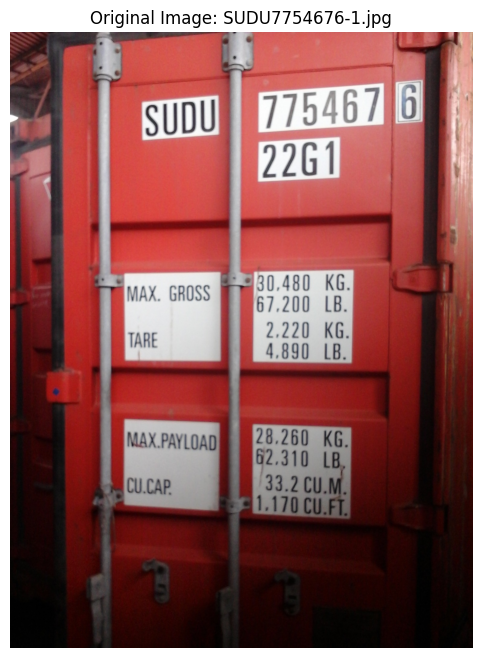

In [ ]:
# Load and display the original image
print(f"\nLoading image from: {IMAGE_PATH}")
image = cv2.imread(str(IMAGE_PATH))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width = image.shape[:2]

print(f"Image dimensions: {width} x {height}")

# Display original image
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title(f"Original Image: {IMAGE_PATH.name}")
plt.axis('off')
plt.show()

In [ ]:
# Run inference with different confidence thresholds
confidence_thresholds = [0.1, 0.25, 0.5, 0.7]
all_results = {}

for conf_threshold in confidence_thresholds:
    print(f"\n{'='*50}")
    print(f"Running inference with confidence threshold: {conf_threshold}")
    
    # Run inference
    results = model(str(IMAGE_PATH), conf=conf_threshold, verbose=False)
    
    # Process results
    detections = []
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        
        for i in range(len(boxes)):
            # Get box coordinates (xyxy format)
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            confidence = float(boxes.conf[i].cpu().numpy())
            class_id = int(boxes.cls[i].cpu().numpy())
            class_name = model.names[class_id]
            
            detection = {
                'class_id': class_id,
                'class_name': class_name,
                'confidence': confidence,
                'x1': int(x1),
                'y1': int(y1),
                'x2': int(x2),
                'y2': int(y2),
                'width': int(x2 - x1),
                'height': int(y2 - y1),
                'area': int((x2 - x1) * (y2 - y1))
            }
            detections.append(detection)
    
    all_results[conf_threshold] = detections
    
    # Print summary
    print(f"Found {len(detections)} detections")
    if detections:
        df = pd.DataFrame(detections)
        print("\nDetection summary:")
        print(df[['class_name', 'confidence', 'x1', 'y1', 'width', 'height', 'area']])


Running inference with confidence threshold: 0.1
Found 2 detections

Detection summary:
           class_name  confidence   x1   y1  width  height    area
0  code_license_plate    0.463367  420  181    837     164  137688
1    code_container_h    0.372618  421  179    842     177  149614

Running inference with confidence threshold: 0.25
Found 2 detections

Detection summary:
           class_name  confidence   x1   y1  width  height    area
0  code_license_plate    0.463367  420  181    837     164  137688
1    code_container_h    0.372618  421  179    842     177  149614

Running inference with confidence threshold: 0.5
Found 0 detections

Running inference with confidence threshold: 0.7
Found 0 detections


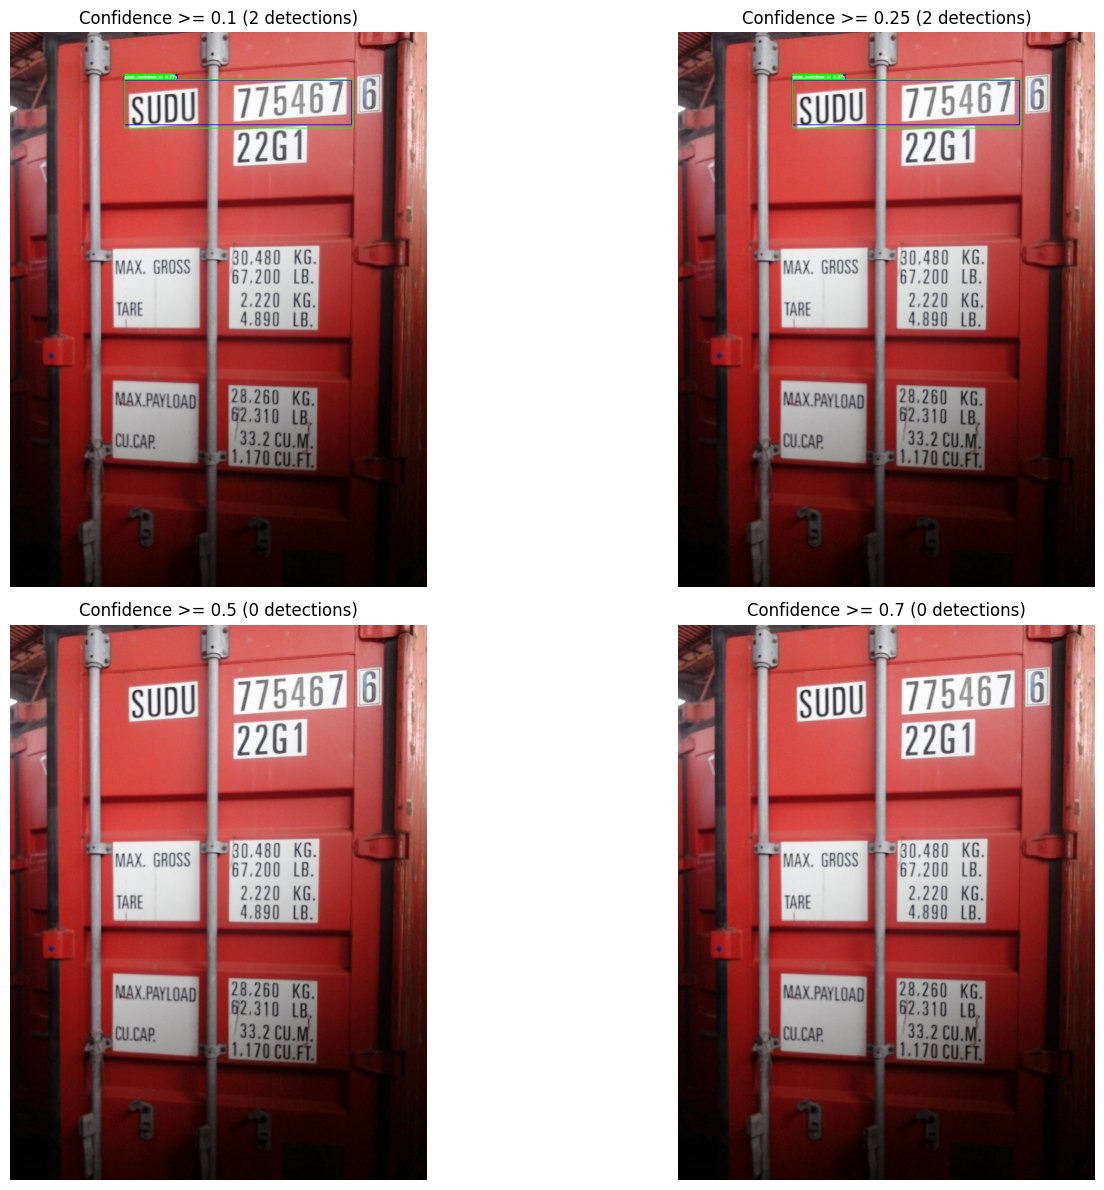

In [ ]:
# Visualize detections at different confidence levels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (conf_threshold, detections) in enumerate(all_results.items()):
    # Create a copy of the image for drawing
    img_copy = image_rgb.copy()
    
    # Draw detections
    for det in detections:
        # Get color for this class
        color = CLASS_COLORS.get(det['class_name'], (255, 255, 255))
        
        # Draw rectangle
        cv2.rectangle(img_copy, 
                     (det['x1'], det['y1']), 
                     (det['x2'], det['y2']), 
                     color, 2)
        
        # Draw label
        label = f"{det['class_name']}: {det['confidence']:.2f}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        
        # Draw label background
        cv2.rectangle(img_copy,
                     (det['x1'], det['y1'] - label_size[1] - 10),
                     (det['x1'] + label_size[0], det['y1']),
                     color, -1)
        
        # Draw label text
        cv2.putText(img_copy, label,
                   (det['x1'], det['y1'] - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Display
    axes[idx].imshow(img_copy)
    axes[idx].set_title(f"Confidence >= {conf_threshold} ({len(detections)} detections)")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


FOCUSING ON code_container_h DETECTIONS ONLY
(This is what inference_and_crop.py looks for)

At confidence threshold 0.25:
Total detections: 2
code_container_h detections: 1


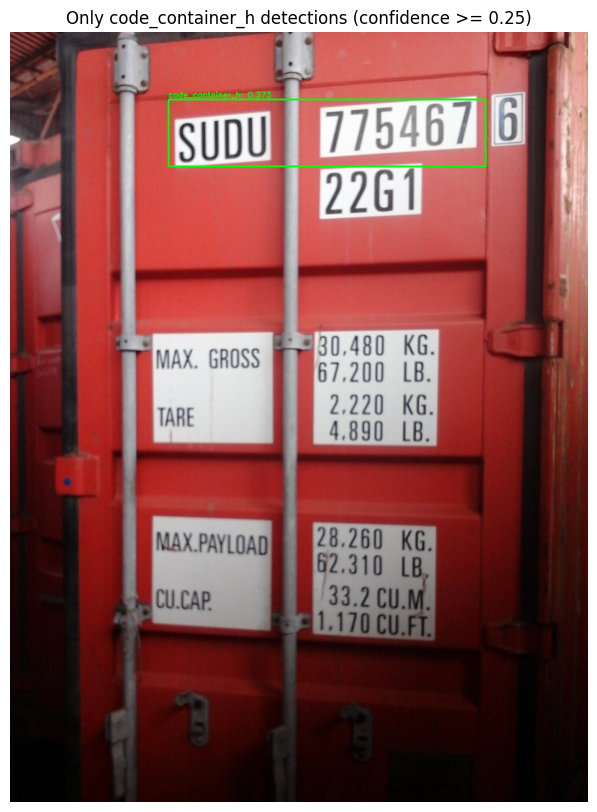


code_container_h detection details:

Detection 1:
  Confidence: 0.373
  Bounding box: (421, 179) to (1264, 357)
  Size: 842 x 177 pixels
  Area: 149614 pixels²
  Area percentage: 4.8% of image


In [ ]:
# Focus on code_container_h detections only (what the crop script looks for)
print("\n" + "="*50)
print("FOCUSING ON code_container_h DETECTIONS ONLY")
print("(This is what inference_and_crop.py looks for)")
print("="*50)

# Create visualization for container_h only
plt.figure(figsize=(15, 10))

# Use confidence threshold 0.25 (default in scripts)
conf_threshold = 0.25
detections = all_results[conf_threshold]

# Filter for code_container_h only
container_h_detections = [d for d in detections if d['class_name'] == 'code_container_h']

print(f"\nAt confidence threshold {conf_threshold}:")
print(f"Total detections: {len(detections)}")
print(f"code_container_h detections: {len(container_h_detections)}")

# Draw image with only container_h detections
img_copy = image_rgb.copy()

for det in container_h_detections:
    # Green for container_h
    color = (0, 255, 0)
    
    # Draw rectangle
    cv2.rectangle(img_copy, 
                 (det['x1'], det['y1']), 
                 (det['x2'], det['y2']), 
                 color, 3)
    
    # Draw label
    label = f"{det['class_name']}: {det['confidence']:.3f}"
    cv2.putText(img_copy, label,
               (det['x1'], det['y1'] - 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

plt.imshow(img_copy)
plt.title(f"Only code_container_h detections (confidence >= {conf_threshold})")
plt.axis('off')
plt.show()

# Print detailed info
if container_h_detections:
    print("\ncode_container_h detection details:")
    for i, det in enumerate(container_h_detections):
        print(f"\nDetection {i+1}:")
        print(f"  Confidence: {det['confidence']:.3f}")
        print(f"  Bounding box: ({det['x1']}, {det['y1']}) to ({det['x2']}, {det['y2']})")
        print(f"  Size: {det['width']} x {det['height']} pixels")
        print(f"  Area: {det['area']} pixels²")
        print(f"  Area percentage: {det['area'] / (width * height) * 100:.1f}% of image")
else:
    print("\n⚠️  NO code_container_h DETECTIONS FOUND!")
    print("This explains why inference_and_crop.py might not be creating outputs.")

In [ ]:
# Check what classes ARE being detected
print("\n" + "="*50)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*50)

for conf_threshold, detections in all_results.items():
    print(f"\nAt confidence threshold {conf_threshold}:")
    
    if detections:
        # Count detections by class
        class_counts = {}
        for det in detections:
            class_name = det['class_name']
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        # Print counts
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count} detections")
    else:
        print("  No detections")


CLASS DISTRIBUTION ANALYSIS

At confidence threshold 0.1:
  code_container_h: 1 detections
  code_license_plate: 1 detections

At confidence threshold 0.25:
  code_container_h: 1 detections
  code_license_plate: 1 detections

At confidence threshold 0.5:
  No detections

At confidence threshold 0.7:
  No detections


In [ ]:
# Test with even lower confidence to see if anything is detected
print("\n" + "="*50)
print("TESTING WITH VERY LOW CONFIDENCE (0.01)")
print("="*50)

# Run with very low confidence
results_low = model(str(IMAGE_PATH), conf=0.01, verbose=False)

if len(results_low) > 0 and results_low[0].boxes is not None:
    boxes = results_low[0].boxes
    print(f"Found {len(boxes)} detections at 0.01 confidence")
    
    # Group by class
    class_detections = {}
    for i in range(len(boxes)):
        confidence = float(boxes.conf[i].cpu().numpy())
        class_id = int(boxes.cls[i].cpu().numpy())
        class_name = model.names[class_id]
        
        if class_name not in class_detections:
            class_detections[class_name] = []
        class_detections[class_name].append(confidence)
    
    # Print confidence ranges by class
    print("\nConfidence ranges by class:")
    for class_name, confidences in sorted(class_detections.items()):
        print(f"\n{class_name}:")
        print(f"  Count: {len(confidences)}")
        print(f"  Min confidence: {min(confidences):.4f}")
        print(f"  Max confidence: {max(confidences):.4f}")
        print(f"  Mean confidence: {np.mean(confidences):.4f}")
else:
    print("No detections even at 0.01 confidence!")


TESTING WITH VERY LOW CONFIDENCE (0.01)
Found 6 detections at 0.01 confidence

Confidence ranges by class:

code_container_h:
  Count: 3
  Min confidence: 0.0121
  Max confidence: 0.3726
  Mean confidence: 0.1352

code_license_plate:
  Count: 3
  Min confidence: 0.0110
  Max confidence: 0.4634
  Mean confidence: 0.1648


In [ ]:
# Test with DISABLED NMS to see all raw detections
print("\n" + "="*50)
print("TESTING WITH DISABLED NMS (Non-Maximum Suppression)")
print("This shows ALL detections before overlap filtering")
print("="*50)

# Run with NMS disabled and very low confidence
# iou=1.0 effectively disables NMS (no overlap threshold)
results_no_nms = model(str(IMAGE_PATH), conf=0.01, iou=1.0, verbose=False)

print("\nWith NMS DISABLED:")
if len(results_no_nms) > 0 and results_no_nms[0].boxes is not None:
    boxes = results_no_nms[0].boxes
    print(f"Found {len(boxes)} RAW detections (before NMS filtering)")
    
    # Collect all detections with detailed info
    all_raw_detections = []
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
        confidence = float(boxes.conf[i].cpu().numpy())
        class_id = int(boxes.cls[i].cpu().numpy())
        class_name = model.names[class_id]
        
        detection = {
            'class_name': class_name,
            'confidence': confidence,
            'x1': int(x1), 'y1': int(y1),
            'x2': int(x2), 'y2': int(y2),
            'width': int(x2 - x1),
            'height': int(y2 - y1),
            'area': int((x2 - x1) * (y2 - y1))
        }
        all_raw_detections.append(detection)
    
    # Sort by confidence (highest first)
    all_raw_detections.sort(key=lambda x: x['confidence'], reverse=True)
    
    # Show top detections
    print("\nTop 15 RAW detections (before NMS):")
    for i, det in enumerate(all_raw_detections[:15]):
        print(f"{i+1:2d}. {det['class_name']:15s} conf={det['confidence']:.4f} bbox=({det['x1']:3d},{det['y1']:3d})-({det['x2']:3d},{det['y2']:3d}) size={det['width']:3d}x{det['height']:3d}")
    
    # Focus on code_container_h detections
    container_h_raw = [d for d in all_raw_detections if d['class_name'] == 'code_container_h']
    print(f"\ncode_container_h RAW detections: {len(container_h_raw)}")
    
    if container_h_raw:
        print("\nALL code_container_h detections (before NMS):")
        for i, det in enumerate(container_h_raw):
            area_pct = det['area'] / (width * height) * 100
            print(f"{i+1}. conf={det['confidence']:.4f} bbox=({det['x1']},{det['y1']})-({det['x2']},{det['y2']}) size={det['width']}x{det['height']} area={area_pct:.1f}%")
        
        # Check if any cover the full container code area
        print("\nAnalyzing detection sizes for full container code coverage...")
        for i, det in enumerate(container_h_raw):
            # Estimate if this might cover the full container code
            # Full container code should be wider (spans across multiple text blocks)
            if det['width'] > 400 and det['height'] > 50:  # Rough estimates for full container
                print(f"  ✓ Detection {i+1} might cover FULL container code (width={det['width']}, height={det['height']})")
            elif det['width'] > 200:
                print(f"  ~ Detection {i+1} covers PARTIAL container code (width={det['width']}, height={det['height']})")
            else:
                print(f"  ✗ Detection {i+1} too small for full container code (width={det['width']}, height={det['height']})")
    else:
        print("  ❌ NO code_container_h detections found even in raw output!")

else:
    print("No detections even with NMS disabled!")

# Compare with normal NMS
print("\n" + "-"*50)
print("COMPARISON: Normal NMS vs No NMS")
print("-"*50)

results_normal = model(str(IMAGE_PATH), conf=0.01, verbose=False)  # Default NMS

normal_count = len(results_normal[0].boxes) if results_normal[0].boxes is not None else 0
no_nms_count = len(results_no_nms[0].boxes) if results_no_nms[0].boxes is not None else 0

print(f"Normal NMS: {normal_count} detections")
print(f"No NMS: {no_nms_count} detections")
print(f"NMS filtered out: {no_nms_count - normal_count} detections")

if no_nms_count > normal_count:
    print("\n⚠️  NMS is filtering out detections! This could explain missing boxes.")
    
    # Show what was filtered out
    if container_h_raw:
        filtered_out = len(container_h_raw) - len([d for d in all_results[0.01] if d['class_name'] == 'code_container_h'])
        print(f"   Specifically for code_container_h: {filtered_out} detections were filtered out by NMS")
else:
    print("\n✓ NMS is not the issue - same number of detections.")


TESTING WITH DISABLED NMS (Non-Maximum Suppression)
This shows ALL detections before overlap filtering

With NMS DISABLED:
Found 13 RAW detections (before NMS filtering)

Top 15 RAW detections (before NMS):
 1. code_license_plate conf=0.4634 bbox=(420,181)-(1257,345) size=837x164
 2. code_container_h conf=0.3726 bbox=(421,179)-(1264,357) size=842x177
 3. code_license_plate conf=0.3033 bbox=(416,181)-(1259,338) size=842x157
 4. code_container_h conf=0.1931 bbox=(421,183)-(1251,359) size=829x176
 5. code_license_plate conf=0.1820 bbox=(420,180)-(1257,353) size=837x172
 6. code_license_plate conf=0.1168 bbox=(432,179)-(1260,332) size=828x153
 7. code_container_h conf=0.0209 bbox=(372,1310)-(810,1391) size=438x 81
 8. code_license_plate conf=0.0199 bbox=(377,1312)-(701,1389) size=324x 76
 9. code_container_h conf=0.0176 bbox=(421,197)-(1189,360) size=768x163
10. code_license_plate conf=0.0121 bbox=(500,183)-(1253,333) size=752x150
11. code_container_h conf=0.0121 bbox=(380,1314)-(688,1385


CROP PREVIEW - What inference_and_crop.py would save
Would create 1 crops:

Crop 1:
  Original bbox: (421, 179) to (1264, 357)
  Padded bbox: (411, 169) to (1274, 367)
  Crop size: 863 x 198 pixels


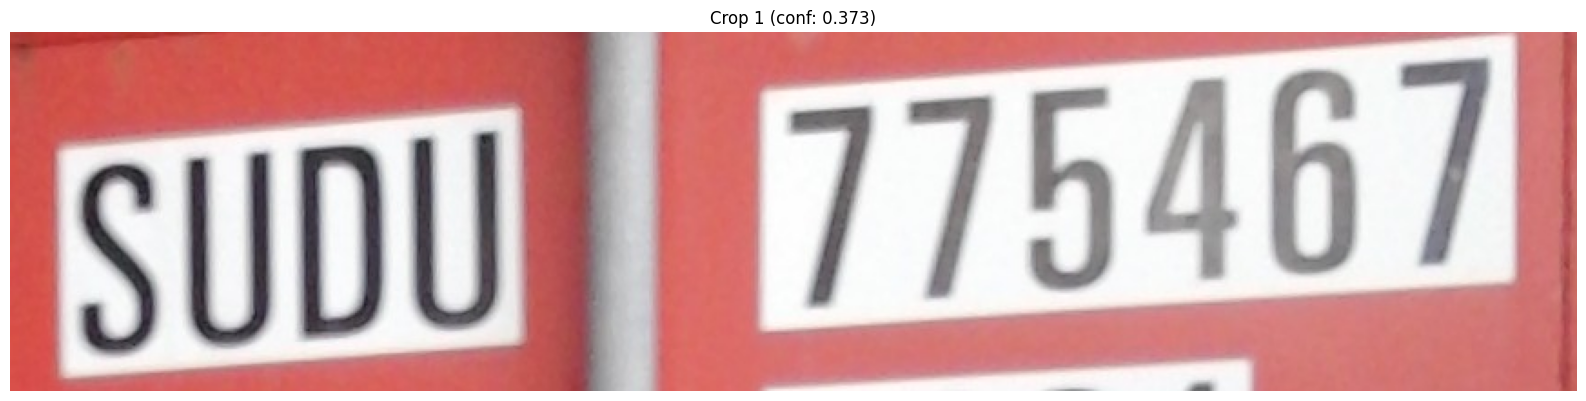

In [ ]:
# Create a crop preview - simulate what inference_and_crop.py would do
print("\n" + "="*50)
print("CROP PREVIEW - What inference_and_crop.py would save")
print("="*50)

# Use default confidence from script
conf_threshold = 0.25
padding = 10  # Default padding from script

container_h_detections = [d for d in all_results[conf_threshold] if d['class_name'] == 'code_container_h']

if container_h_detections:
    print(f"Would create {len(container_h_detections)} crops:")
    
    # Create figure to show crops
    n_crops = len(container_h_detections)
    fig, axes = plt.subplots(1, min(n_crops, 4), figsize=(16, 4))
    if n_crops == 1:
        axes = [axes]
    
    for idx, det in enumerate(container_h_detections[:4]):
        # Calculate crop with padding
        x1 = max(0, det['x1'] - padding)
        y1 = max(0, det['y1'] - padding)
        x2 = min(width, det['x2'] + padding)
        y2 = min(height, det['y2'] + padding)
        
        # Crop image
        crop = image_rgb[y1:y2, x1:x2]
        
        # Display
        axes[idx].imshow(crop)
        axes[idx].set_title(f"Crop {idx+1} (conf: {det['confidence']:.3f})")
        axes[idx].axis('off')
        
        print(f"\nCrop {idx+1}:")
        print(f"  Original bbox: ({det['x1']}, {det['y1']}) to ({det['x2']}, {det['y2']})")
        print(f"  Padded bbox: ({x1}, {y1}) to ({x2}, {y2})")
        print(f"  Crop size: {x2-x1} x {y2-y1} pixels")
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ NO CROPS WOULD BE CREATED - No code_container_h detections found!")
    print("\nThis is why inference_and_crop.py produces no output for this image.")

## Summary and Recommendations

Based on the visualization above, we can see:

1. **What classes are being detected** - Check if the model is detecting the expected classes
2. **Confidence levels** - See if detections are below the threshold
3. **Bounding box locations** - Verify if boxes are in the right places
4. **code_container_h specific** - See if this specific class is being detected

### Common issues:
- Model might be detecting containers as `code_container_v` instead of `code_container_h`
- Confidence threshold might be too high
- Model might need more training data for this specific type of image